In [1]:
## classification algo

## THINGS TRIED:
# voting classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

# 1. 2-class classification with SVC & RF
# 2. finding optimal hyperparameters
# 3. checked with reduced feature set (from corr map & PCA)
# 4. changing threshold


import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
#from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import auc,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix

from datetime import datetime

In [2]:
######################  functions #########################

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


#################################################################################

In [3]:
#################################################################################################################

### using individual epoch data ###

file_location='C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\Pickle_Files_6nov2018'
os.chdir('C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\Pickle_Files_6nov2018') 

In [4]:
# remove xls for 2nd night of subject 13, as there was data loss - dfull pkl file created accordingly
# read in all xls, & then the sheets

dfull = pickle.load(open('dfull_6nov.pkl', 'rb'))

In [5]:
dfull.head(2)

,pat_id,day,segment,epoch,delta,theta,alpha,beta,gamma,class
0,400,1,Seg1,1,0.703302,0.146348,0.099262,0.037832,0.018150,wake
1,400,1,Seg1,2,0.580056,0.166110,0.089898,0.058965,0.049103,wake


In [6]:
dfull.describe()

,delta,theta,alpha,beta,gamma
count,92994.000000,92994.000000,92994.000000,92994.000000,92994.000000
mean,0.548548,0.174441,0.107626,0.064444,0.051732
std,0.134191,0.054266,0.036677,0.030566,0.038432
min,0.004729,0.001743,0.001243,0.005787,0.002457
25%,0.465643,0.137236,0.083090,0.043786,0.024816
50%,0.558102,0.171532,0.103252,0.058310,0.041107
75%,0.643137,0.208692,0.127330,0.077500,0.066582
max,1.391141,0.494500,0.387486,0.333226,0.334687


In [7]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92994 entries, 0 to 92993
Data columns (total 10 columns):
pat_id     92994 non-null object
day        92994 non-null object
segment    92994 non-null object
epoch      92994 non-null object
delta      92994 non-null float64
theta      92994 non-null float64
alpha      92994 non-null float64
beta       92994 non-null float64
gamma      92994 non-null float64
class      92994 non-null object
dtypes: float64(5), object(5)
memory usage: 7.1+ MB


In [8]:
dfull.groupby('class').size()

class
sleep_stage_1     2804
sleep_stage_2    17799
wake             72391
dtype: int64

In [9]:
### Convert from 3-class to 2-class ####

dfull['class2'] = dfull['class']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

# wake=0 & sleepy = 1
# we want to correctly identify sleepiness
# so we want to maximise sensitivity/recall/TPR : TP/ (TP + FN)
#              proportion of actual positives/ sick people who are correctly identified as having the condition

# precision or PPV = TP/ (TP + FP) 
#              proportion of actual positives/ sick people among those which the test predicts as sick

In [10]:
dfull.dtypes

pat_id      object
day         object
segment     object
epoch       object
delta      float64
theta      float64
alpha      float64
beta       float64
gamma      float64
class       object
class2       int64
dtype: object

In [11]:
## convert selected columns to categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search

dfull[['class']] = dfull[['class']].astype('str')        # ,'class2'
dfull[['class']] = dfull[['class']].astype('category')   # ,'class2'

In [11]:
'''
### create a smaller subset of data for testing algo
dw = dfull[(dfull['class'] == 'wake')]
d1 = dfull[(dfull['class'] == 'sleep_stage_1')]
d2 = dfull[(dfull['class'] == 'sleep_stage_2')]

# https://stackoverflow.com/questions/15923826/random-row-selection-in-pandas-dataframe
# Randomly sample n elements from your dataframe
d1_elements = d1.sample(n=2800)
d2_elements = d2.sample(n=2800)
dw_elements = dw.sample(n=5600)

dn = pd.DataFrame()
dn = pd.concat([dw_elements, d1_elements, d2_elements],ignore_index=True)
dn.shape[0]
'''

11200

In [12]:
#dn.head(2)

,pat_id,day,segment,epoch,delta,theta,alpha,beta,gamma,class,class2
0,402,2,Seg6,923,0.708408,0.161242,0.091274,0.035758,0.019526,wake,0
1,407,2,Seg1,344,0.449978,0.180864,0.145975,0.079258,0.075636,wake,0


In [12]:
## create train-test data : 2 class; with appropriate feature columns
#X = dn[['delta','theta','alpha','beta','gamma']]  # dfull[['delta','theta','alpha','beta','gamma']]
#y = dn[['class2']]  # dfull[['class']] 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# use 'stratify=True' for consistent class distribution between training and test sets

Train = pd.read_excel("C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\training_data_2class.xlsx")
Test = pd.read_excel("C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\test_data_2class.xlsx")
X_train = Train[['delta','theta','alpha','beta','gamma']]
X_test = Test[['delta','theta','alpha','beta','gamma']]
y_train = Train[['class2']]
y_test = Test[['class2']]


## normalize the data  : can also use other scalers like StandardScaler()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape

(8960, 5)

In [27]:
X_train_scaled

array([[0.46, 0.45, 0.32, 0.16, 0.08],
       [0.41, 0.46, 0.42, 0.24, 0.11],
       [0.36, 0.33, 0.3 , 0.24, 0.29],
       ...,
       [0.43, 0.5 , 0.36, 0.15, 0.04],
       [0.48, 0.47, 0.25, 0.16, 0.05],
       [0.42, 0.48, 0.34, 0.19, 0.09]])

In [28]:
X_test_scaled

array([[0.53, 0.49, 0.2 , 0.07, 0.02],
       [0.22, 0.4 , 0.57, 0.48, 0.34],
       [0.37, 0.5 , 0.33, 0.19, 0.19],
       ...,
       [0.43, 0.26, 0.28, 0.32, 0.19],
       [0.36, 0.54, 0.26, 0.23, 0.2 ],
       [0.41, 0.42, 0.37, 0.28, 0.14]])

In [13]:
y_train.groupby('class2').size()

class2
0    4508
1    4452
dtype: int64

In [14]:
y_test.groupby('class2').size()

class2
0    1092
1    1148
dtype: int64

In [17]:
#### MODEL definitions ####
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier

# optimised SVC MODEL 
model_svc_opt = SVC(C=1000, kernel='linear')

# other SVC
model_svc = SVC()

# optimised RF
model_rf_opt = RandomForestClassifier(max_features = 3, min_samples_split = 10, n_estimators = 501) 

# other RF
model_rf = RandomForestClassifier(max_features='auto', min_samples_split=2, n_estimators = 501)

#RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#            max_depth=None, max_features='auto', max_leaf_nodes=None,
#            min_impurity_decrease=0.0, min_impurity_split=None,
#           min_samples_leaf=1, min_samples_split=2,
#            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
#            oob_score=False, random_state=None, verbose=0,
#            warm_start=False)

# knn
model_knn = KNeighborsClassifier(metric='euclidean', n_neighbors=5)


## voting classifier
eclf_hrd = VotingClassifier(estimators=[('svc_opt', model_svc_opt), ('svc', model_svc), 
                                        ('rf_opt', model_rf_opt), ('rf', model_rf),
                                        ('knn', model_knn)], voting='hard')

In [18]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-12 14:48:16'

In [19]:
## fit model - vary ML algo & hyperparameters

eclf_hrd.fit(X_train_scaled, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('svc_opt', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('svc', SVC(C=1.0, cache_size=200, class_weig...idean',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [20]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-12 14:48:48'

In [21]:
# predict on test data - check metrics
y_pred = eclf_hrd.predict(X_test_scaled)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [22]:
y_pred

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [30]:
y_pred.shape

(2240,)

Confusion matrix, without normalization
[[936 156]
 [215 933]]
Normalized confusion matrix
[[0.86 0.14]
 [0.19 0.81]]


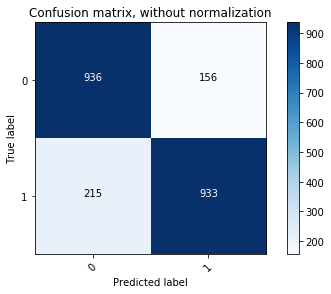

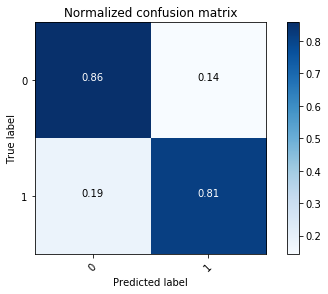

In [23]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

             precision    recall  f1-score   support

          0       0.81      0.86      0.83      1092
          1       0.86      0.81      0.83      1148

avg / total       0.84      0.83      0.83      2240



In [25]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test,y_pred) 

(array([0.81, 0.86]),
 array([0.86, 0.81]),
 array([0.83, 0.83]),
 array([1092, 1148], dtype=int64))

In [26]:
p = precision_recall_fscore_support(y_test,y_pred) 
sen = p[1][1]
spec = p[1][0]
print('sen: ' + str(sen) +' , spec: ' + str(spec))

sen: 0.8127177700348432 , spec: 0.8571428571428571


In [37]:
## voting classifier 2
# optimised SVC MODEL 
model_svc_opt = SVC(C=1000, kernel='linear', probability=True)

# other SVC
model_svc = SVC(probability=True)


eclf_sft = VotingClassifier(estimators=[('svc_opt', model_svc_opt), ('svc', model_svc), 
                                        ('rf_opt', model_rf_opt), ('rf', model_rf),
                                        ('knn', model_knn)], voting='soft')

In [38]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-12 15:31:50'

In [39]:
## fit model - vary ML algo & hyperparameters
eclf_sft.fit(X_train_scaled, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('svc_opt', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('svc', SVC(C=1.0, cache_size=200, class_weigh...idean',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [40]:
datetime.now().strftime('%Y-%m-%d %H:%M:%S')

'2018-11-12 15:32:59'

In [41]:
# predict on test data - check metrics
y_pred_sf = eclf_sft.predict(X_test_scaled)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_sf, target_names=class_names))

             precision    recall  f1-score   support

          0       0.82      0.86      0.84      1092
          1       0.86      0.82      0.84      1148

avg / total       0.84      0.84      0.84      2240



In [43]:
p = precision_recall_fscore_support(y_test,y_pred_sf) 
sen = p[1][1]
spec = p[1][0]
print('sen: ' + str(sen) +' , spec: ' + str(spec))

sen: 0.8170731707317073 , spec: 0.8571428571428571


Confusion matrix, without normalization
[[936 156]
 [210 938]]
Normalized confusion matrix
[[0.86 0.14]
 [0.18 0.82]]


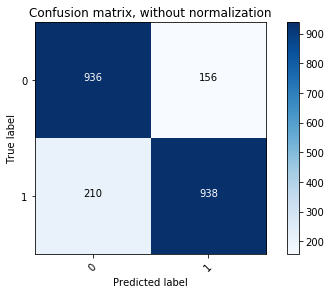

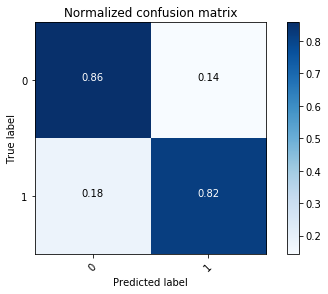

In [44]:
####    Compute confusion matrix     ####

class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'

cnf_matrix = confusion_matrix(y_test, y_pred_sf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
## show predictions from individual models as well as from voting classifier

In [45]:
# fit model
model_svc_opt.fit(X_train_scaled, y_train)

# predict on test data - check metrics
y_pred_svc_opt = model_svc_opt.predict(X_test_scaled)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
model_svc.fit(X_train_scaled, y_train)
y_pred_svc = model_svc.predict(X_test_scaled)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
model_rf_opt.fit(X_train_scaled, y_train)
y_pred_rf_opt = model_rf_opt.predict(X_test_scaled)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [48]:
model_rf.fit(X_train_scaled, y_train)
y_pred_rf = model_rf.predict(X_test_scaled)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [49]:
model_knn.fit(X_train_scaled, y_train)
y_pred_knn = model_knn.predict(X_test_scaled)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


In [51]:
y_pred_svc_opt

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [52]:
y_pred_svc_opt = pd.DataFrame(y_pred_svc_opt)
y_pred_svc_opt.head(2)

,0
0,0
1,1


In [53]:
y_pred_svc = pd.DataFrame(y_pred_svc)
y_pred_rf = pd.DataFrame(y_pred_rf)
y_pred_rf_opt = pd.DataFrame(y_pred_rf_opt)
y_pred_knn = pd.DataFrame(y_pred_knn)
y_pred_sf = pd.DataFrame(y_pred_sf)
y_pred = pd.DataFrame(y_pred)

In [60]:
print(y_pred_svc_opt.shape)
print(y_pred_svc.shape)
print(y_pred_rf_opt.shape)
print(y_pred_rf.shape)
print(y_pred_knn.shape)
print(y_pred_sf.shape)
print(y_pred.shape)

(2240, 1)
(2240, 1)
(2240, 1)
(2240, 1)
(2240, 1)
(2240, 1)
(2240, 1)


In [54]:
predictions = pd.concat([y_pred_svc_opt, y_pred_svc, y_pred_rf_opt, y_pred_rf, y_pred_knn, y_pred_sf, y_pred],axis=1)

In [55]:
predictions.head(2)

,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1


In [56]:
predictions.columns=['y_pred_svc_opt', 'y_pred_svc', 'y_pred_rf_opt', 'y_pred_rf', 'y_pred_knn', 'y_pred_softVote', 'y_pred_hardVote']
predictions.head(2)

,y_pred_svc_opt,y_pred_svc,y_pred_rf_opt,y_pred_rf,y_pred_knn,y_pred_softVote,y_pred_hardVote
0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1


In [58]:
y_test.shape

(2240, 1)

In [61]:
predictions = pd.DataFrame()
predictions = pd.concat([y_pred_svc_opt, y_pred_svc],axis=1) # y_pred_rf_opt, y_pred_rf, y_pred_knn, y_pred_sf, y_pred  
predictions.shape

(2240, 2)

In [62]:
predictions = pd.concat([predictions,y_pred_rf_opt],axis=1) # y_pred_rf, y_pred_knn, y_pred_sf, y_pred  
predictions.shape

(2240, 3)

In [63]:
predictions = pd.concat([predictions, y_pred_rf, y_pred_knn],axis=1) # y_pred_rf_opt, y_pred_rf, y_pred_knn, y_pred_sf, y_pred  
predictions.shape

(2240, 5)

In [64]:
predictions = pd.concat([predictions, y_pred_sf, y_pred],axis=1) # y_pred_rf_opt, y_pred_rf, y_pred_knn, y_pred_sf, y_pred  
predictions.shape

(2240, 7)

In [68]:
Pred = pd.DataFrame()
yt = y_test.reset_index()
Pred = pd.concat([predictions, yt], axis=1)
Pred.shape

(2240, 9)

In [69]:
Pred.head(2)

,0,0,0,0,0,0,0,index,class2
0,0,0,0,0,0,0,0,7324,1
1,1,1,1,1,1,1,1,3193,0


In [70]:
yt.head(2)

,index,class2
0,7324,1
1,3193,0


In [71]:
Pred = Pred.drop('index', axis=1)

In [72]:
Pred.head(2)

,0,0,0,0,0,0,0,class2
0,0,0,0,0,0,0,0,1
1,1,1,1,1,1,1,1,0


In [74]:
Pred.columns=['y_pred_svc_opt', 'y_pred_svc', 'y_pred_rf_opt', 'y_pred_rf', 'y_pred_knn', 'y_pred_softVote', 'y_pred_hardVote', 'y_test']
Pred.head(2)

,y_pred_svc_opt,y_pred_svc,y_pred_rf_opt,y_pred_rf,y_pred_knn,y_pred_softVote,y_pred_hardVote,y_test
0,0,0,0,0,0,0,0,1
1,1,1,1,1,1,1,1,0


In [75]:
Pred.to_excel("C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\voting_classifier_2class.xlsx")

In [77]:
## get subset where predictions from all algos match ground truth

match = Pred[(Pred.y_test == Pred.y_pred_svc) & (Pred.y_test == Pred.y_pred_rf) & (Pred.y_test == Pred.y_pred_rf_opt) 
           & (Pred.y_test == Pred.y_pred_svc_opt) & (Pred.y_test == Pred.y_pred_knn) ]

In [78]:
match.shape

(1555, 8)

In [79]:
match.head(3)

,y_pred_svc_opt,y_pred_svc,y_pred_rf_opt,y_pred_rf,y_pred_knn,y_pred_softVote,y_pred_hardVote,y_test
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
6,1,1,1,1,1,1,1,1


In [80]:
## get subset where predictions from all algos are mis-matched with ground truth
mismatch = Pred[(Pred.y_test != Pred.y_pred_svc) & (Pred.y_test != Pred.y_pred_rf) & (Pred.y_test != Pred.y_pred_rf_opt) 
           & (Pred.y_test != Pred.y_pred_svc_opt) & (Pred.y_test != Pred.y_pred_knn) ]

In [81]:
mismatch.shape

(212, 8)

In [82]:
mismatch.head(3)

,y_pred_svc_opt,y_pred_svc,y_pred_rf_opt,y_pred_rf,y_pred_knn,y_pred_softVote,y_pred_hardVote,y_test
0,0,0,0,0,0,0,0,1
1,1,1,1,1,1,1,1,0
19,0,0,0,0,0,0,0,1


In [84]:
## get the remaining pediction cases
df2 = Pred[~( (Pred.y_test == Pred.y_pred_svc) & (Pred.y_test == Pred.y_pred_rf) & (Pred.y_test == Pred.y_pred_rf_opt) 
           & (Pred.y_test == Pred.y_pred_svc_opt) & (Pred.y_test == Pred.y_pred_knn) )]

In [85]:
df3 = df2[~( (df2.y_test != df2.y_pred_svc) & (df2.y_test != df2.y_pred_rf) & (df2.y_test != df2.y_pred_rf_opt) 
           & (df2.y_test != df2.y_pred_svc_opt) & (df2.y_test != df2.y_pred_knn) )]

In [86]:
df3.shape

(473, 8)

In [87]:
df3.head(3)

,y_pred_svc_opt,y_pred_svc,y_pred_rf_opt,y_pred_rf,y_pred_knn,y_pred_softVote,y_pred_hardVote,y_test
4,0,0,1,0,1,0,0,0
5,0,0,1,1,0,0,0,0
11,0,0,1,1,1,0,1,0


In [88]:
## check matches with hard voting
m_hd = Pred[(Pred.y_test == Pred.y_pred_hardVote)]
print(m_hd.shape)

(1869, 8)


In [89]:
## check matches with soft voting
m_sf = Pred[(Pred.y_test == Pred.y_pred_softVote)]
print(m_sf.shape)

(1874, 8)


In [90]:
## check common
mm = Pred[(Pred.y_test == Pred.y_pred_hardVote) & (Pred.y_test == Pred.y_pred_softVote)]
print(mm.shape)

(1842, 8)


In [ ]:
####################################################################

#################   pca   ########################

In [72]:
from sklearn import decomposition
pca = decomposition.PCA()  # n_components = N; should be <= #features
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(pca.explained_variance_ratio_)

[0.8  0.13 0.04 0.02 0.01]


In [80]:
X_train_pca

array([[ 0.07, -0.03,  0.  ,  0.01, -0.01],
       [ 0.  , -0.03,  0.03,  0.01, -0.01],
       [-0.06,  0.06, -0.01, -0.01, -0.02],
       ...,
       [ 0.04, -0.05,  0.  ,  0.02, -0.01],
       [ 0.1 , -0.03, -0.01,  0.  ,  0.01],
       [ 0.02, -0.03,  0.  ,  0.01, -0.  ]])

In [82]:
## predict using 1st two PCs
from sklearn import decomposition
pca = decomposition.PCA(n_components = 2)  # n_components = N; should be <= #features
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [83]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2018-11-08 15:15:55


In [84]:
model_rf = RandomForestClassifier(n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
# max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2
model_rf.fit(X_train_pca, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2018-11-08 15:16:07


In [86]:
# predict on test data - check metrics
y_pred = model_rf.predict(X_test_pca)

In [87]:
print(classification_report(y_test, y_pred, target_names=class_names))

## COMMENT: RF model (n_estimators=501) withh all 5 features gave recall=0.84

             precision    recall  f1-score   support

          0       0.54      0.55      0.54      1092
          1       0.56      0.55      0.56      1148

avg / total       0.55      0.55      0.55      2240



In [24]:
## predict using 1st three PCs
from sklearn import decomposition

pca = decomposition.PCA(n_components = 3)  # n_components = N; should be <= #features
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [25]:
model_rf_pc = RandomForestClassifier(max_features = 3, min_samples_split = 10, n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
# max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2
model_rf_pc.fit(X_train_pca, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
y_pred = model_rf_pc.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=class_names))

             precision    recall  f1-score   support

          0       0.70      0.73      0.71      1092
          1       0.73      0.70      0.71      1148

avg / total       0.71      0.71      0.71      2240



In [27]:
## predict using 1st 4 PCs
from sklearn import decomposition

pca = decomposition.PCA(n_components = 4)  # n_components = N; should be <= #features
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [28]:
model_rf_pc = RandomForestClassifier(max_features = 3, min_samples_split = 10, n_estimators = 501) ## max_depth=5, random_state=0,verbose =0)  
# max_features=2, min_samples_split=4, n_estimators=50, min_samples_leaf=2
model_rf_pc.fit(X_train_pca, y_train)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=501, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
y_pred = model_rf_pc.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=class_names))

             precision    recall  f1-score   support

          0       0.77      0.84      0.80      1092
          1       0.83      0.77      0.80      1148

avg / total       0.80      0.80      0.80      2240



In [ ]:
##################################################################################################################

########################  INCREASING DATASET SIZE , iterations  #################################################